<IPython.core.display.Javascript object>


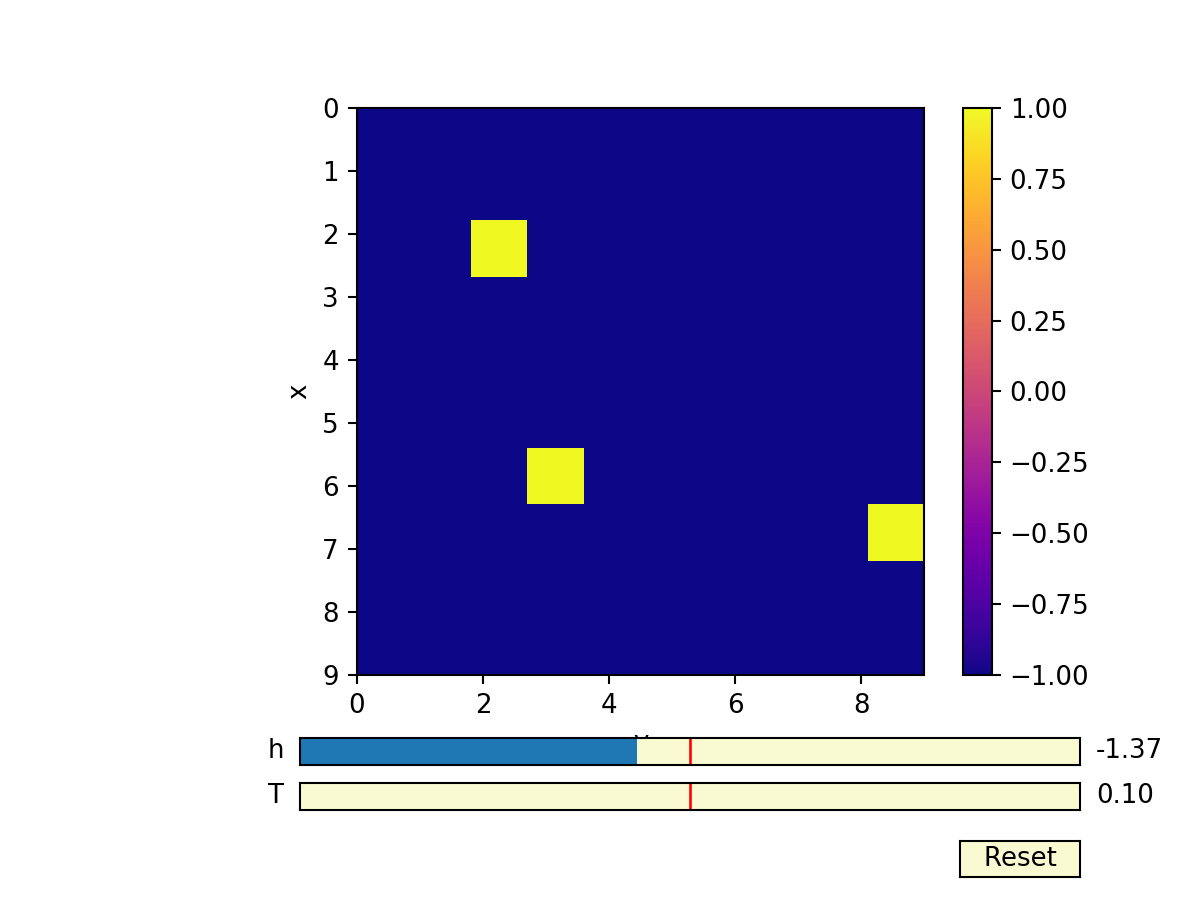

In [27]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
%matplotlib notebook

global L, T, h, kb, MCS, J, spin_site_total_number

L = 10   # Number of spin sites in one dimension
T = 50  # Temperature in Kelvin
h = 0    # External magnetic field
spin_site_total_number = L**2
MCS = L**2
J = 1
kb = 1
spin_init = 'random'
 
grid_x, grid_y = [range(L), range(L)]
grid_coordinates_x, grid_coordinates_y = np.meshgrid(grid_x, grid_y) 
grid_coordinates_x, grid_coordinates_y = [np.reshape(grid_coordinates_x,(1,-1)), np.reshape(grid_coordinates_y,(1,-1))]
spin_site_numbers = range(spin_site_total_number)

grid_spins = assign_spin(spin_init)

E_system = system_energy(grid_coordinates_x, grid_coordinates_y, grid_spins)

ani, m_slider, T_slider, reset_button = animation_function(grid_coordinates_x, grid_coordinates_y, grid_spins, E_system)


In [1]:
def grid_plot(x, y, S):
    image = plt.imshow(S, extent=(x.min(), x.max(), y.max(), y.min()), interpolation='nearest', cmap=cm.plasma)
    plt.clim(-1,1)
    plt.xlabel('y')
    plt.ylabel('x')
    return image

def assign_spin(spin_init):
    if spin_init == 'random':
        grid_spins = rnd.rand(L,L)
        grid_spins[grid_spins >= 0.5] = 1
        grid_spins[grid_spins <  0.5] = -1
        
    elif spin_init == 'up':
        grid_spins = np.ones([L,L], dtype= int)
        
    elif spin_init == 'down':
        grid_spins = -1*np.ones([L,L], dtype= int)
        
    return grid_spins

def spin_site_energy(spin_site_x, spin_site_y, grid_spins):
    spin_site_energy = 0
    
    spin_neigbour_x = (spin_site_x + np.array([1, -1, 0, 0]))%(L)
    spin_neigbour_y = (spin_site_y + np.array([0, 0, 1, -1]))%(L)
    
    for i in range(np.size(spin_neigbour_x)):
        spin_value_center = grid_spins[spin_site_x, spin_site_y]
        spin_value_neighbour = grid_spins[spin_neigbour_x[i], spin_neigbour_y[i]]

        spin_site_energy += -J*spin_value_center*spin_value_neighbour - h*spin_value_center
    return spin_site_energy 

def system_energy(grid_coordinates_x, grid_coordinates_y, grid_spins):
    sys_energy = 0
    for spin_site_number in spin_site_numbers:
        spin_site_x = grid_coordinates_x[0][spin_site_number]
        spin_site_y = grid_coordinates_y[0][spin_site_number]
        sys_energy += spin_site_energy(spin_site_x, spin_site_y, grid_spins)
    sys_energy = sys_energy/2 # To counter double counting of the links
    return sys_energy


def spin_flip(grid_coordinates_x, grid_coordinates_y, grid_spins, E_system):
    spin_site_number = rnd.randint(0, spin_site_total_number)
    spin_site_x = grid_coordinates_x[0][spin_site_number]
    spin_site_y = grid_coordinates_y[0][spin_site_number]
       
    spin_site_energy_pre_flip = spin_site_energy(spin_site_x, spin_site_y, grid_spins)
    grid_spins[spin_site_x, spin_site_y] = -1 * grid_spins[spin_site_x, spin_site_y]
    spin_site_energy_post_flip = spin_site_energy(spin_site_x, spin_site_y, grid_spins)    
    spin_flip_energy_delta = spin_site_energy_post_flip - spin_site_energy_pre_flip
        
    if spin_flip_energy_delta <= 0:
        E_system += 2 * spin_flip_energy_delta
        
    elif spin_flip_energy_delta > 0:
        boltzman_chance = np.exp(-spin_flip_energy_delta/(kb*T))
        boltzmon_pick = rnd.random()
        
        if  boltzman_chance > boltzmon_pick:
            E_system += 2 * spin_flip_energy_delta
            
        elif boltzman_chance <= boltzmon_pick:  
            grid_spins[spin_site_x, spin_site_y] = -1 * grid_spins[spin_site_x, spin_site_y]
            
    return grid_spins, E_system


In [26]:
from matplotlib.widgets import Slider, Button, RadioButtons
   
def animation_function(x, y, grid_spins, E_system):
    fig = plt.figure()
    
    im = plt.imshow(grid_spins, extent=(x.min(), x.max(), y.max(), y.min()), 
                    interpolation='nearest', cmap=cm.plasma, animated=True)
    plt.clim(-1, 1)
    plt.xlabel('y')
    plt.ylabel('x')
    plt.colorbar()
 
    axis_color = 'lightgoldenrodyellow'

    ax = fig.add_subplot(111)

    # Adjust the subplots region to leave some space for the sliders and buttons
    fig.subplots_adjust(left=0.25, bottom=0.25)

    # Add two sliders for tweaking the parameters

    # Define an axes area and draw a slider in it
    m_slider_ax  = fig.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
    m_slider = Slider(m_slider_ax, 'h', -10.0, 10.0, valinit=h)

    # Draw another slider
    T_slider_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03], facecolor=axis_color)
    T_slider = Slider(T_slider_ax, 'T', 0.1, 100.0, valinit=T)

    # Define an action for modifying the line when any slider's value changes
    def sliders_on_changed(val):
        global h, T
        h = m_slider.val
        T = T_slider.val
        
    m_slider.on_changed(sliders_on_changed)
    T_slider.on_changed(sliders_on_changed)

    # Add a button for resetting the parameters
    reset_button_ax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
    reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')
    
    def reset_button_on_clicked(mouse_event):
        T_slider.reset()
        m_slider.reset()
        
    reset_button.on_clicked(reset_button_on_clicked)
    
    def data_fig(grid_coordinates_x, grid_coordinates_y, grid_spins, E_system):
        grid_spins, E_system = spin_flip(grid_coordinates_x, grid_coordinates_y, grid_spins, E_system)
        return grid_spins
    
    def updatefig(*args):
        im.set_array(data_fig(grid_coordinates_x, grid_coordinates_y, grid_spins, E_system))
        return im
    
    ani = animation.FuncAnimation(fig, updatefig, interval=1, blit=True)
    plt.show()
    return ani, m_slider, T_slider, reset_button